In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
from pydataset import data
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# import our own acquire module
import acquire
import env
import prepare

**Using the titanic data, in your classification-exercises repository, create a notebook, decision_tree.ipynb where you will do the following:**

Read in Titanic data

In [2]:
directory = os.getcwd()

titanic_query = 'select * from passengers'
titanic = acquire.get_titanic_data(titanic_query, directory, filename = 'titanic.csv')
titanic.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [3]:
train, val, test = prepare.split_data(prepare.wrangle_data('titanic'), 'titanic')
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone
474,0,3,female,22.0,0,0,9.8375,Southampton,1
370,1,1,male,25.0,1,0,55.4417,Cherbourg,0
573,1,3,female,30.0,0,0,7.7500,Queenstown,1
110,0,1,male,47.0,0,0,52.0000,Southampton,1
167,0,3,female,45.0,1,4,27.9000,Southampton,0


In [4]:
def preprocess_titanic(train, val, test, continuous_features=['age', 'fare']):
    '''
    preprocess titanic will encode any categorical features
    and proceed forward with using a minmax scaler to transform 
    continuous variables.
    
    return: three dataframes, train, validate, and test, preprocessed for modeling
    '''
    # iterate through our three dataframes
    for df in [train, val, test]:
        # assign out the encoded categoricals for embark_town
        # in the same way on all three datasets
        df[['is_queenstown', 'is_southampton']] = pd.get_dummies(df.embark_town,
               drop_first=True).astype(int).values
    # create a single scaler object
    scaler = MinMaxScaler()
    # fit the single scaler just once to train
    scaler.fit(train[continuous_features])
    # apply that transformation to all three data sets
    # using the same syntax, which conconates
    # '_scaled' to each feature name that was fed in
    for df in [train, val, test]:
        df[[continuous_features[0]+'_scaled', continuous_features[1]+'_scaled']] = \
        scaler.transform(df[continuous_features])
    for df in [train, val, test]:
        df['is_female'] = np.where(df['sex'] == 'female', 1, 0)
    preprocessed_dfs = []
    for df in [train, val, test]:
        preprocessed_dfs.append(df.drop(columns=['sex', 'age', 'fare', 'embark_town']))
    return preprocessed_dfs

In [5]:
train_processed, val_processed, test_processed = preprocess_titanic(train, val, test) #### Let's get this ready for ML
train_processed.head()

,survived,pclass,sibsp,parch,alone,is_queenstown,is_southampton,age_scaled,fare_scaled,is_female
474,0,3,0,0,1,0,1,0.303285,0.019202,1
370,1,1,1,0,0,0,0,0.345941,0.108215,0
573,1,3,0,0,1,1,0,0.417034,0.015127,1
110,0,1,0,0,1,0,1,0.658752,0.101497,0
167,0,3,1,4,0,0,1,0.630314,0.054457,1


**What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.**

In [6]:
train_processed.survived.value_counts() #### My baseline prediction is based off '0', as it has a higher value count for the target column of 'survived'.

0    307
1    191
Name: survived, dtype: int64

In [7]:
baseline_accuracy = (train_processed.survived == 0).mean()
baseline_accuracy

0.6164658634538153

**Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)**



In [8]:
#### First I need to split my X and y

In [9]:
X_train = train_processed.drop(columns=['survived']) #### I only want my features here, not the target of 'survived'
X_validate = val_processed.drop(columns=['survived'])
X_test = test_processed.drop(columns=['survived'])

In [10]:
y_train = train_processed.survived
y_validate = val_processed.survived
y_test = test_processed.survived

In [11]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [12]:
clf = clf.fit(X_train, y_train)

In [13]:
clf.predict(X_train)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,

In [14]:
clf.score(X_train, y_train)

0.8333333333333334

**Evaluate your in-sample results using the model score, confusion matrix, and classification report.**



In [15]:
y_pred = clf.predict(X_train)

In [16]:
conf = confusion_matrix(y_train, y_pred)
conf

array([[279,  28],
       [ 55, 136]])

In [20]:
labels = sorted(y_train.unique())
labels

[0, 1]

In [21]:
pd.DataFrame(conf)

,0,1
0,279,28
1,55,136


In [17]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       307
           1       0.83      0.71      0.77       191

    accuracy                           0.83       498
   macro avg       0.83      0.81      0.82       498
weighted avg       0.83      0.83      0.83       498



**Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.**



In [18]:
conf

array([[279,  28],
       [ 55, 136]])

In [22]:
pd.DataFrame(conf,
            index=[str(label) + '_actual'for label in labels],
            columns=[str(label) + '_predict'for label in labels])

,0_predict,1_predict
0_actual,279,28
1_actual,55,136


In [23]:
conf.ravel()

array([279,  28,  55, 136])

In [24]:
TN, FP, FN, TP = conf.ravel()
TN, FP, FN, TP

(279, 28, 55, 136)

In [25]:
all_ = (TP + TN + FP + FN)

accuracy = (TP + TN) / all_

TPR = recall = TP / (TP + FN)
FPR = FP / (FP + TN)

TNR = TN / (FP + TN)
FNR = FN / (FN + TP)

precision =  TP / (TP + FP)
f1 =  2 * ((precision * recall) / ( precision + recall))

support_pos = TP + FN
support_neg = FP + TN

In [26]:
print(f"Accuracy: {accuracy}\n")
print(f"True Positive Rate/Sensitivity/Recall/Power: {TPR}")
print(f"False Positive Rate/False Alarm Ratio/Fall-out: {FPR}")
print(f"True Negative Rate/Specificity/Selectivity: {TNR}")
print(f"False Negative Rate/Miss Rate: {FNR}\n")
print(f"Precision/PPV: {precision}")
print(f"F1 Score: {f1}\n")
print(f"Support (0): {support_pos}")
print(f"Support (1): {support_neg}")

Accuracy: 0.8333333333333334

True Positive Rate/Sensitivity/Recall/Power: 0.7120418848167539
False Positive Rate/False Alarm Ratio/Fall-out: 0.09120521172638436
True Negative Rate/Specificity/Selectivity: 0.9087947882736156
False Negative Rate/Miss Rate: 0.2879581151832461

Precision/PPV: 0.8292682926829268
F1 Score: 0.7661971830985914

Support (0): 191
Support (1): 307


**Run through steps 2-4 using a different max_depth value.**



In [27]:
#for one
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.7931726907630522

In [28]:
#for lots
for x in range(1,20):
#     print(x)
    clf = DecisionTreeClassifier(max_depth=x)
    clf.fit(X_train, y_train)
    acc = clf.score(X_train, y_train)
    print(f'for depth of {x:2}, the accuracy is {round(acc,2)}')

for depth of  1, the accuracy is 0.79
for depth of  2, the accuracy is 0.8
for depth of  3, the accuracy is 0.83
for depth of  4, the accuracy is 0.84
for depth of  5, the accuracy is 0.86
for depth of  6, the accuracy is 0.88
for depth of  7, the accuracy is 0.89
for depth of  8, the accuracy is 0.9
for depth of  9, the accuracy is 0.92
for depth of 10, the accuracy is 0.94
for depth of 11, the accuracy is 0.96
for depth of 12, the accuracy is 0.97
for depth of 13, the accuracy is 0.98
for depth of 14, the accuracy is 0.98
for depth of 15, the accuracy is 0.98
for depth of 16, the accuracy is 0.98
for depth of 17, the accuracy is 0.98
for depth of 18, the accuracy is 0.98
for depth of 19, the accuracy is 0.98


**Which model performs better on your in-sample data?**



In [29]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = clf.score(X_validate, y_validate)
    
    scores_all.append([x, train_acc, val_acc])

In [30]:
scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df.head()

,max_depth,train_acc,val_acc
0,1,0.793173,0.742991
1,2,0.801205,0.761682
2,3,0.833333,0.775701
3,4,0.843373,0.775701
4,5,0.861446,0.785047


In [32]:
scores_df['diff'] = scores_df.train_acc - scores_df.val_acc

In [33]:
scores_df.sort_values('diff')

,max_depth,train_acc,val_acc,diff
1,2,0.801205,0.761682,0.039523
0,1,0.793173,0.742991,0.050182
2,3,0.833333,0.775701,0.057632
3,4,0.843373,0.775701,0.067673
4,5,0.861446,0.785047,0.076399
5,6,0.877510,0.780374,0.097136
6,7,0.891566,0.766355,0.125211
7,8,0.899598,0.733645,0.165954
8,9,0.919679,0.742991,0.176688
9,10,0.939759,0.747664,0.192095


In [35]:
#The model with a max depth of 8 or greater perform the best with in-sample data

**Which model performs best on your out-of-sample data, the validate set?**

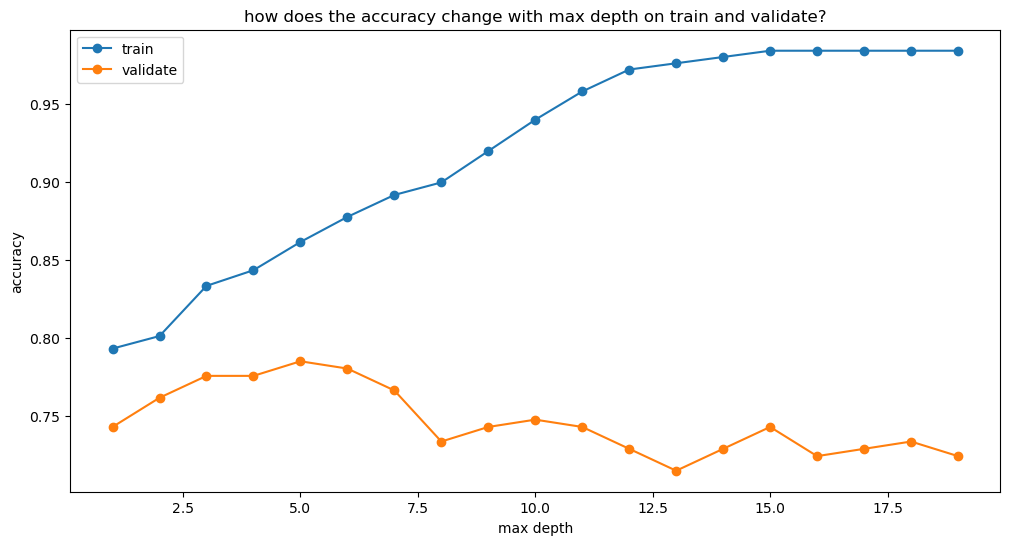

In [34]:
plt.figure(figsize=(12,6))
plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
plt.plot(scores_df.max_depth, scores_df.val_acc, label='validate', marker='o')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('how does the accuracy change with max depth on train and validate?')
plt.legend()
plt.show()